## Configure environment

In [1]:
%%capture
%pip install torch torchvision h5py xarray matplotlib netcdf4

In [2]:
import random
import time
import os
import datetime
import itertools
import math
import sys
from random import randint

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.utils.data as data
from torch.utils.data import DataLoader
import numpy as np
import h5py
import PIL.Image
from IPython.core import display as idisplay
import matplotlib.pyplot as plt
import xarray as xr

from vae import VAE, vae_loss_fn
sys.path.append('../common')
import common

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
common.set_memory_limit_if_not_limit(1.5)

In [5]:
os.makedirs('save', exist_ok=True)

## Load data

In [6]:
cwd = os.getcwd()
pardir = os.path.dirname(os.path.dirname(cwd))
data_folder = os.path.join(pardir,'data')
data_path = os.path.join(data_folder,'video_prediction_dataset.hdf5')
mask_path = os.path.join('assets','mask_black_skygptdata.png')
model_name = 'CNNLSTM'
output_path = os.path.join(cwd,"save", f"{model_name}.torch")
with h5py.File(data_path, 'r') as fds:
    group_names = list(fds.keys())
    print(group_names)

dss = {}
for gname in group_names:
    dss[gname] = xr.open_dataset(data_path, group=gname)

['test', 'trainval']


In [7]:
print(dss['test']['images_log'])
print(dss['test']['images_log'].shape)

<xarray.DataArray 'images_log' (phony_dim_0: 4467, phony_dim_1: 16,
                                phony_dim_2: 64, phony_dim_3: 64, phony_dim_4: 3)>
[878247936 values with dtype=uint8]
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2,
                                phony_dim_3, phony_dim_4
(4467, 16, 64, 64, 3)


In [8]:
mask_png = np.array(PIL.Image.open(mask_path).resize((64, 64)).getdata())
# Mask for size 64
print(mask_png.shape)
mask_to_black = (mask_png[:,3] > 127)
not_mask_to_black = (mask_png[:,3] <= 127)
print(mask_to_black.sum()) # alpha = 1 = black visible
print(not_mask_to_black.sum())
print(not_mask_to_black.sum()+mask_to_black.sum())
mask_to_black = mask_to_black.reshape((64, 64))
empty_mask = np.ones((64, 64, 3))
mask_to_black = np.where(np.expand_dims(mask_to_black, 2), empty_mask, empty_mask*0)


(4096, 4)
1674
2422
4096


In [97]:
bs = 256 # batch size
transform = transforms.Compose([
    transforms.Lambda(lambda x: np.where(mask_to_black, x*0, x)),
    #v2.functional.adjust_contrast(),
    transforms.ToPILImage(), # This already normalizes the image
    transforms.Lambda(v2.functional.autocontrast),
    transforms.Resize(64),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.float()),
    #transforms.Normalize(mean=[0.5], std=[0.5])  # Example normalization
])
# Create Dataset and DataLoader
train_dataset = common.VideoDataset(dss['trainval']['images_log'], dss['trainval']['images_pred'], transform=transform, stack_videos=True)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = common.VideoDataset(dss['test']['images_log'], dss['test']['images_pred'], transform=transform, stack_videos=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

print(f"Number of videos: {len(train_dataset.videos)}.")
print(f"Number of video batches: {len(train_loader)}")
print(f"Size of video batches: {bs}.")

Number of videos: 53336.
Number of video batches: 209
Size of video batches: 256.


torch.Size([31, 3, 64, 64])
Number of images per video: 31
Number of images per batch: 7936


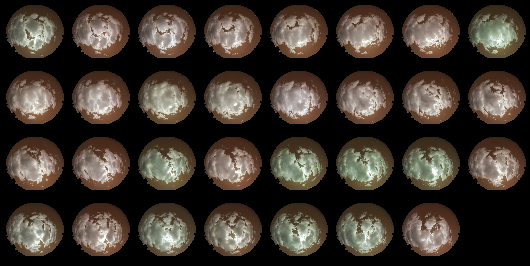

In [10]:
# Fixed input for debugging
fixed_x = next(iter(train_loader))
print(fixed_x[0].shape) # 0 because VideoDataset has batch_size videos, not images.
print(f"Number of images per video: {fixed_x[0].shape[0]}")
print(f"Number of images per batch: {fixed_x[0].shape[0]*bs}")
torchvision.utils.save_image(fixed_x[0], 'save/real_image.png')
idisplay.Image('save/real_image.png')

In [11]:
#cnn = torch.nn.Conv2d()
#rnn = torch.nn.LSTM()

In [12]:
image_channels = fixed_x[0].size(1)

In [13]:
#vae = VAE(image_channels=image_channels).to(device)
vae = VAE(image_channels=image_channels, z_dim=64).to(device)
last_epoch = 0
if os.path.exists(output_path):
    vae.load_state_dict(torch.load(output_path, map_location='cpu'))
    last_epoch = 11
else:
    print('No states loaded')

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(vae))

4448323


In [15]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3) 

In [16]:
epochs = 20

In [17]:
for epoch in range(last_epoch, epochs):
    vae.train()
    for idx, (videos) in enumerate(train_loader):
        images = torch.stack([img[randint(0, len(img)-1)] for img in videos])
        # Only taking the first into account, all images of videos are very similar
        #images = videos.flatten(0,1)
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = vae_loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if idx % 10 == 0:
            to_print = (
                f"Epoch[{epoch+1}/{epochs}] B[{idx+1}/{len(train_loader)}] Loss: {loss.data.item()/bs:.4g} "
                f"{bce.data.item()/bs:.4g} {kld.data.item()/bs:.3g}"
            )
            print(to_print)
    torch.save(vae.state_dict(), output_path)


Epoch[1/20] B[1/209] Loss: 9288 9288 0.000484
Epoch[1/20] B[11/209] Loss: 6056 6056 0.00835
Epoch[1/20] B[21/209] Loss: 5214 5214 0.0111
Epoch[1/20] B[31/209] Loss: 4893 4893 0.0145
Epoch[1/20] B[41/209] Loss: 4756 4756 0.0159
Epoch[1/20] B[51/209] Loss: 4717 4717 0.0164
Epoch[1/20] B[61/209] Loss: 4651 4651 0.0172
Epoch[1/20] B[71/209] Loss: 4637 4637 0.0169
Epoch[1/20] B[81/209] Loss: 4619 4619 0.0169
Epoch[1/20] B[91/209] Loss: 4594 4594 0.0167
Epoch[1/20] B[101/209] Loss: 4569 4569 0.0169
Epoch[1/20] B[111/209] Loss: 4562 4562 0.0166
Epoch[1/20] B[121/209] Loss: 4535 4535 0.0171
Epoch[1/20] B[131/209] Loss: 4540 4540 0.0171
Epoch[1/20] B[141/209] Loss: 4525 4525 0.017
Epoch[1/20] B[151/209] Loss: 4531 4531 0.017
Epoch[1/20] B[161/209] Loss: 4517 4517 0.0172
Epoch[1/20] B[171/209] Loss: 4502 4502 0.0172
Epoch[1/20] B[181/209] Loss: 4528 4528 0.0174
Epoch[1/20] B[191/209] Loss: 4521 4521 0.0177
Epoch[1/20] B[201/209] Loss: 4501 4501 0.0177
Epoch[2/20] B[1/209] Loss: 4528 4528 0.0179


KeyboardInterrupt: 

In [18]:
def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

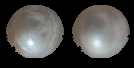

In [329]:
vae.eval()
fixed_x = train_dataset[randint(1, 5000)][0].unsqueeze(0)
compare_x = compare(fixed_x)

torchvision.utils.save_image(compare_x.data.cpu(), 'save/sample_image.png')
display(idisplay.Image('save/sample_image.png', width=700, unconfined=True))

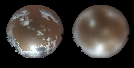

In [332]:
vae.eval()
fixed_x = test_dataset[randint(0, 4466)][0].unsqueeze(0)
compare_x = compare(fixed_x)

torchvision.utils.save_image(compare_x.data.cpu(), 'save/sample_image.png')
display(idisplay.Image('save/sample_image.png', width=700, unconfined=True))